In [2]:
params_notebook_name = "datasets.eclip_peaks_and_rbp_selection.py.ipynb"
params_resource_dir = "../resources/"


params_subset_chroms = []

params_subset_rbp_cl = []

params_tmp_dir = None


output_closeby_peaks_df_filepath = "./closeby_peaks_df.tsv"

# eCLIP peaks and RBP selection

## Overview

We want here to establish a subset of peaks and associated RBPs where we have evidence of
co-binding by these RBPs.

The purpose of this subset of regions will be to explore the relationship between the binding
events from these RBPs, as seen by the PARNET models:

- at the embedding level (through dependency maps) ;
- at the predicted signal level (through peaks and integrated gradients).


Questions to answer with these selected regions:

- using dependency maps, do we detect the dependencies between peaks within a region?
  - From the same RBP (e.g. QKI periodicity in motifs)
  - From different RBPs (e.g. RBPs co-binding, RBP binding complexes)


Additional exploration : evaluate the impact of genomic annotations overlap on the representations.

⇒ Demo of extracting per position annotation.


## Imports

In [3]:
import dataclasses
import datetime
import itertools as itt
import os
import sys
import tempfile
import warnings
from dataclasses import asdict
from io import StringIO
from numbers import Number
from pathlib import Path
from typing import Literal, Optional

import memelite
import networkx
import numpy as np
import pandas as pd
import pybedtools as pbt
import pyBigWig as pbw
import pydantic.dataclasses
import pyfaidx
import requests
import tangermeme
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from dotenv import find_dotenv, load_dotenv
from dotmap import DotMap
from IPython.display import HTML, SVG, Image, display
from pydantic.dataclasses import dataclass
from snakemake.io import glob_wildcards

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def assert_notebook_working_dir(expected_local_file: os.PathLike) -> Path:
    """Assert or try updating the current working directory to where the notebook is located, to enable relative paths references.

    This function is used in a set-up where notebooks are contained within a project
    directory structure in which we want to reference filepaths relative to the notebook.
    e.g. "../src" or "../resources" should be accessible if the notebook is in
    "../notebooks/<notebook_name>.ipynb".

    The function first check the filepath of the expected local file relative
    to the current working directory.

    If not found, the function will try to use the VSCode Jupyter variable `__vsc_ipynb_file__`
    which should report the path of the notebook file being executed.

    It then checks if the expected local file exists, relative to the new working directory.


    Args:
        expected_local_file (os.PathLike): The expected local file to check for in the current working directory.
            This can be the name of the notebook file.

    Raises:
        KeyError: if the `__vsc_ipynb_file__` variable is not found in the global scope, while the first CWD check failed.
        FileNotFoundError: if the expected local file is not found in the current working directory after attempting to change it.
    """
    import os
    from pathlib import Path

    cwd = Path(os.getcwd())
    expected_local_filepath = cwd / expected_local_file

    if not expected_local_filepath.exists():
        if "__vsc_ipynb_file__" not in globals():
            raise KeyError(
                f"Detected CWD: {cwd} ; CWD does not contain expected file, but cannot use __vsc_ipynb_file__ to recover."
            )
        else:
            os.chdir(Path(globals()["__vsc_ipynb_file__"]).parent)
            cwd = Path(os.getcwd())
            print(f"Changed CWD to {cwd}")

            expected_local_filepath = cwd / expected_local_file
            if not expected_local_filepath.exists():
                raise FileNotFoundError(
                    f"Updated (using __vsc_ipynb_file__) CWD: {cwd} ; CWD does not contain expected file."
                )

            return cwd
    else:
        print(f"Confirmed CWD: {cwd} contains expected file: {expected_local_file}")
        return cwd


expected_local_file: str = params_notebook_name
cwd = assert_notebook_working_dir(expected_local_file=expected_local_file)
print(cwd)

Confirmed CWD: /home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks contains expected file: datasets.eclip_peaks_and_rbp_selection.py.ipynb
/home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks


## Init

In [6]:
resource_dir = Path("../resources/")

In [7]:
bed6_cols = ["chrom", "start", "end", "name", "score", "strand"]
gff_columns = [
    "seqid",
    "source",
    "biotype",
    "start",
    "end",
    "score",
    "strand",
    "phase",
    "attributes",
]

In [174]:
# Caution: pyBedTools relies on tmp dir, which can get quite large.
def create_randomized_tmp_dir(parent_dir: os.PathLike | None = None) -> str:
    # Get the parent tmp dir where to create a randomized tmp dir.

    if parent_dir is not None:
        parent_tmp_dir = Path(parent_dir)
        # Make the directory
        if not parent_tmp_dir.exists():
            parent_tmp_dir.mkdir(parents=True, exist_ok=True)

    # Default system value
    if parent_tmp_dir is None:
        parent_tmp_dir = Path(tempfile.gettempdir())

    if params_tmp_dir is not None:
        parent_tmp_dir = Path(params_tmp_dir)

    if os.getenv("TMP_DIR") is not None:
        parent_tmp_dir = Path(os.getenv("TMP_DIR"))

    if os.getenv("TMP") is not None:
        parent_tmp_dir = Path(os.getenv("TMP"))

    if parent_tmp_dir is None:
        raise ValueError("No temporary directory specified or found.")

    # Test write access to the parent tmp dir
    if not parent_tmp_dir.is_dir():
        raise NotADirectoryError(f"Parent tmp dir is not a directory: {parent_tmp_dir}")

    if not os.access(parent_tmp_dir, os.W_OK):
        raise PermissionError(f"Parent tmp dir is not writable: {parent_tmp_dir}")

    # Make a randomized tmp dir
    tmp_dir = tempfile.mkdtemp(dir=parent_tmp_dir)
    return tmp_dir


tmp_dir = create_randomized_tmp_dir(parent_dir="./tmp_datasets_eclip_peaks_and_rbp_selection/")
print("Using temporary directory for pyBedTools:", tmp_dir)

pbt.set_tempdir(tmp_dir)

Using temporary directory for pyBedTools: tmp_datasets_eclip_peaks_and_rbp_selection/tmpybbhj3s1


## Load

### RBPs metadata

In [8]:
# Loading the metadata from the PARNET model so as to focus on the relevant RBPs before subsetting.

rbp_ct_metadata_filepath = resource_dir / "parnet_models/full_rbp_set.tsv"
rbp_ct_metadata = pd.read_csv(
    rbp_ct_metadata_filepath,
    sep="\t",
    header=0,
)

display(rbp_ct_metadata.head(5))


,rbp_ct,rbp,ct
0,AARS_K562,AARS,K562
1,AATF_K562,AATF,K562
2,ABCF1_K562,ABCF1,K562
3,AGGF1_HepG2,AGGF1,HepG2
4,AGGF1_K562,AGGF1,K562


In [9]:
fp = "../resources/parnet_encore_eclip/rbps_metadata/yeo_RBP_annotation.function.csv"
rbp_functions = pd.read_csv(fp, sep=",").set_index("name").iloc[:, 1:]

# Drop some of the functions:
rbp_functions_drop = [
    "Essential Genes",
    "Viral RNA regulation",
    "Novel RBP",
    "Other",
]

rbp_functions = rbp_functions.drop(columns=rbp_functions_drop)
display(rbp_functions.head(3))


fp = "../resources/parnet_encore_eclip/rbps_metadata/yeo_RBP_annotation.domains.csv"
rbp_domains = pd.read_csv(fp, sep=",").set_index("name").iloc[:, 1:]

display(rbp_domains.head(3))

,Splicing regulation,Spliceosome,RNA modification,3' end processing,rRNA processing,Ribosome & basic translation,RNA stability & decay,microRNA processing,RNA localization,RNA export,Translation regulation,tRNA regulation,mitochondrial RNA regulation,snoRNA / snRNA / telomerase,P-body / stress granules,Exon Junction Complex
name,,,,,,,,,,,,,,,,
A1CF,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
AARS,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
AATF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,RRM,ZNF,KH,Helicase,Nuclease,dRBM,PUM_HD
name,,,,,,,
A1CF,1,0,0,0,0,0,0
AARS,0,0,0,0,0,0,0
AATF,0,0,0,0,0,0,0


### Genome

In [10]:
genome_filepath = resource_dir / "general" / "genome" / "hg38.chrom.sizes"
print('Loading the "genome file" from:', genome_filepath)

genome_file = pd.read_csv(genome_filepath, header=None, sep="\t")
genome_file.columns = ["chrom", "size"]

main_autosomes = [f"chr{i}" for i in range(1, 23)]
sex_chromosomes = ["chrX", "chrY"]
mitochondrial_chromosome = ["chrM"]
main_chromosomes = list(set(main_autosomes) | set(sex_chromosomes) | set(mitochondrial_chromosome))

print(f"Main chromosomes: {', '.join(main_autosomes + sex_chromosomes + mitochondrial_chromosome)}")
print("\n")

display(genome_file.head(5).assign(size=lambda x: x["size"].map("{:_}".format)))

print(
    f"Total number of positions from the main chromosomes: {genome_file.loc[genome_file['chrom'].isin(main_chromosomes), 'size'].sum():_}"
)

print("\n")

other_chromosomes = sorted(list(set(genome_file.chrom) - set(main_chromosomes)))

print(f"Number of additional chromosome regions: {len(other_chromosomes):_}")
print("Examples: " + ", ".join(other_chromosomes[:3]))

Loading the "genome file" from: ../resources/general/genome/hg38.chrom.sizes
Main chromosomes: chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22, chrX, chrY, chrM




,chrom,size
0,chr1,248_956_422
1,chr2,242_193_529
2,chr3,198_295_559
3,chr4,190_214_555
4,chr5,181_538_259


Total number of positions from the main chromosomes: 3_088_286_401


Number of additional chromosome regions: 430
Examples: chr10_GL383545v1_alt, chr10_GL383546v1_alt, chr10_KI270824v1_alt


### Gene annotations

#### MANE

In [11]:
filepath = (
    resource_dir / "general" / "gene_annotations.hg38.MANE_v1.4" / "MANE.GRCh38.v1.4.ensembl_genomic.genes.bed.gz"
)
mane_gene_annotations = pd.read_csv(
    filepath,
    sep="\t",
    compression="gzip",
    header=None,
    comment="#",
    names=bed6_cols,
)
display(mane_gene_annotations.head(5))


,chrom,start,end,name,score,strand
0,chr1,65418,71585,ENSG00000186092.7,.,+
1,chr1,450739,451678,ENSG00000284733.2,.,-
2,chr1,685715,686654,ENSG00000284662.2,.,-
3,chr1,923922,944575,ENSG00000187634.13,.,+
4,chr1,944202,959309,ENSG00000188976.11,.,-


#### GENCODE

### Peaks

Two sets available: 

- NarrowPeaks: main difficulty is that the peaks were called per experimental replicates, i.e. two files to manipulate per RBP_CT (note: the third file of "agreeing" peaks is very limited in size)

- PureCLIP cross-link sites:

In [196]:
narrow_peaks_filepath = (
    resource_dir / "parnet_encore_eclip/bed10_peaks_narrowpeaks/hg38/{RBP_CT}" / "narrowPeak.1_1-2_1.bed.gz"
)

narrow_peaks = {}

for RBP_CT in rbp_ct_metadata["rbp_ct"].unique():
    print(f"RBP_CT: {RBP_CT}")
    filepath = str(narrow_peaks_filepath).format(RBP_CT=RBP_CT)
    df = (
        pd.read_csv(
            filepath,
            sep="\t",
            compression="gzip",
            header=None,
            comment="#",
            names=bed6_cols + ["uk1", "uk2", "uk3", "uk4"],
        )
        .sort_values(by=["chrom", "start"])
        .reset_index(drop=True)
    )

    # We will build a new name for each peak.
    df["name"] = RBP_CT + "_" + df.reset_index()["index"].astype(str)

    narrow_peaks[RBP_CT] = df

RBP_CT: AARS_K562
RBP_CT: AATF_K562
RBP_CT: ABCF1_K562
RBP_CT: AGGF1_HepG2
RBP_CT: AGGF1_K562
RBP_CT: AKAP1_HepG2
RBP_CT: AKAP1_K562
RBP_CT: AKAP8L_K562
RBP_CT: APOBEC3C_K562
RBP_CT: AQR_HepG2
RBP_CT: AQR_K562
RBP_CT: BCCIP_HepG2
RBP_CT: BCLAF1_HepG2
RBP_CT: BUD13_HepG2
RBP_CT: BUD13_K562
RBP_CT: CDC40_HepG2
RBP_CT: CPEB4_K562
RBP_CT: CPSF6_K562
RBP_CT: CSTF2_HepG2
RBP_CT: CSTF2T_HepG2
RBP_CT: CSTF2T_K562
RBP_CT: DDX21_K562
RBP_CT: DDX24_K562
RBP_CT: DDX3X_HepG2
RBP_CT: DDX3X_K562
RBP_CT: DDX42_K562
RBP_CT: DDX51_K562
RBP_CT: DDX52_HepG2
RBP_CT: DDX52_K562
RBP_CT: DDX55_HepG2
RBP_CT: DDX55_K562
RBP_CT: DDX59_HepG2
RBP_CT: DDX6_HepG2
RBP_CT: DDX6_K562
RBP_CT: DGCR8_HepG2
RBP_CT: DGCR8_K562
RBP_CT: DHX30_HepG2
RBP_CT: DHX30_K562
RBP_CT: DKC1_HepG2
RBP_CT: DROSHA_HepG2
RBP_CT: DROSHA_K562
RBP_CT: EFTUD2_HepG2
RBP_CT: EFTUD2_K562
RBP_CT: EIF3D_HepG2
RBP_CT: EIF3G_K562
RBP_CT: EIF3H_HepG2
RBP_CT: EIF4G2_K562
RBP_CT: EWSR1_K562
RBP_CT: EXOSC5_HepG2
RBP_CT: EXOSC5_K562
RBP_CT: FAM120A_HepG2
R

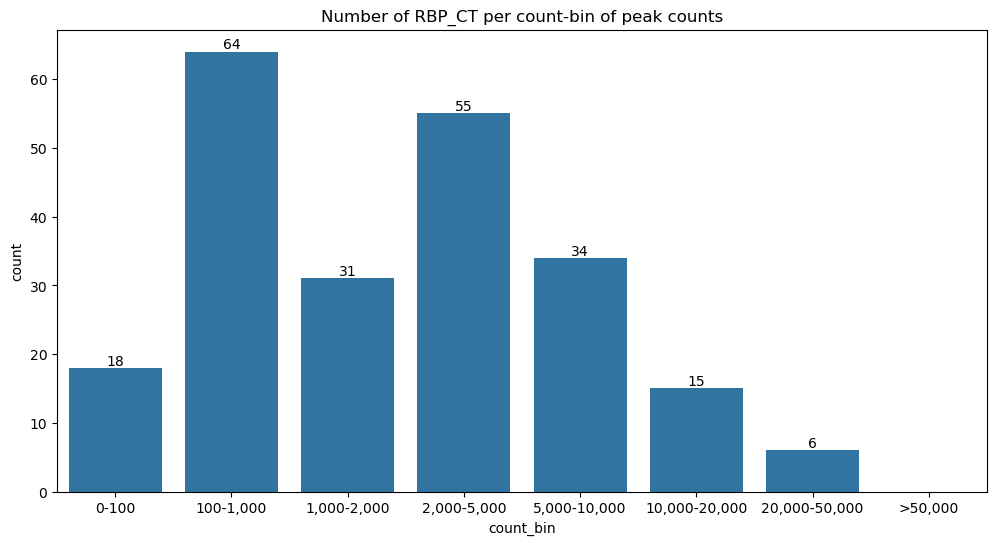

In [197]:
# In this cell: number of RBP_CT = f(number peaks per RBP_CT)
# ===========================================================

tmp = pd.DataFrame([(k, v.shape[0]) for k, v in narrow_peaks.items()], columns=["rbp_ct", "count"])

bins = [0, 100, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000, np.inf]
bins_labels = [
    "0-100",
    "100-1,000",
    "1,000-2,000",
    "2,000-5,000",
    "5,000-10,000",
    "10,000-20,000",
    "20,000-50,000",
    ">50,000",
]
tmp["count_bin"] = pd.cut(
    tmp["count"],
    bins=bins,
    labels=bins_labels,
)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
sns.barplot(
    data=tmp["count_bin"].value_counts().reset_index(),
    x="count_bin",
    y="count",
    order=bins_labels,
    ax=ax1,
)

# Add label on top of each bar
for p in ax1.patches:
    if isinstance(p.get_height(), Number) and p.get_height() > 0:
        _ = ax1.annotate(
            f"{int(p.get_height()):_}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )


_ = ax1.set_title("Number of RBP_CT per count-bin of peak counts")

### Models

## Process

### Prepare data

In [198]:
# Prepare the list of bedtools objects for all the peaks;
# this will be required for the `multiinter` tool (which accepts path to bedtools objects).

ct_peaks_rbp_ct_list: dict[str, list[str]] = {}  # CT to list of RBPs.
ct_peaks_rbp_ct_bt: dict[str, list[pbt.BedTool]] = {}

for ct in ["HepG2", "K562"]:
    peaks_rbp_ct_list = []
    peaks_rbp_ct_bt = []

    for rbp_ct, df in narrow_peaks.items():
        if rbp_ct.endswith(ct):
            peaks_rbp_ct_list.append(rbp_ct)
            peaks_rbp_ct_bt.append(pbt.BedTool.from_dataframe(df))

    ct_peaks_rbp_ct_list[ct] = peaks_rbp_ct_list
    ct_peaks_rbp_ct_bt[ct] = peaks_rbp_ct_bt

# NOTE: the previous block separated the peaks by cell type so as to
# facilitate the identification of regions with peaks from different RBPs
# in the `multiinter` step (rather than having regions with multi-intersections
# of peaks from the same RBP but different cell types).


# Below we also prepare the list of bedtools objects for all the peaks from both cell types.

both_peaks_rbp_ct_list: list[str] = []
both_peaks_rbp_ct_bt: list[pbt.BedTool] = []

for rbp_ct, df in narrow_peaks.items():
    if rbp_ct.endswith(ct):
        both_peaks_rbp_ct_list.append(rbp_ct)
        both_peaks_rbp_ct_bt.append(pbt.BedTool.from_dataframe(df))


### Identify regions with co-binding

In [199]:
# Here for demo we will use only the HepG2 peaks

peaks_rbp_ct_list = ct_peaks_rbp_ct_list["HepG2"]
peaks_rbp_ct_bt = ct_peaks_rbp_ct_bt["HepG2"]


# Set the following parameter so as to define the maximum distance between two peaks.
params_flank_extend = 150


In [16]:
output_closeby_peaks_df_filepath = Path(output_closeby_peaks_df_filepath)

if output_closeby_peaks_df_filepath.exists():
    print(f"Output file {output_closeby_peaks_df_filepath} already exists, skipping the computation.")
    closeby_peaks_df = pd.read_csv(output_closeby_peaks_df_filepath, sep="\t", header=0)

else:
    closeby_peaks: list[pd.DataFrame] = []

    for chrom in main_chromosomes:
        for strand in ["+", "-"]:
            print(f"Processing chrom: {chrom} ; strand: {strand}")

            # 1. Extract all transcripts from the chrom and the strand.
            # ---------------------------------------------------------

            chrom_strand_genes = mane_gene_annotations.loc[
                lambda df: ((df["chrom"] == chrom) & (df["strand"] == strand)), :
            ].copy()

            bt_chrom_strand_genes = pbt.BedTool.from_dataframe(chrom_strand_genes)

            # 2. Subset the peaks on the windows.
            # -----------------------------------

            peaks_rbp_ct_bt_subset = [
                bt.intersect(bt_chrom_strand_genes, wa=True, u=True, s=True).sort() for bt in peaks_rbp_ct_bt
            ]

            # 3. Extend the peaks so as to increase the number of occurrences of
            # "close-by" peaks when multi-intersecting the windows with the peaks.
            # --------------------------------------------------------------------

            extended_peaks_rbp_ct_bt_subset = [
                bt.slop(b=params_flank_extend, s=True, g=genome_filepath).sort() for bt in peaks_rbp_ct_bt_subset
            ]

            # 5. Multi-intersect the extended peaks
            # -------------------------------------

            bt_intersect = pbt.BedTool().multiinter(
                i=[bt.fn for bt in extended_peaks_rbp_ct_bt_subset],
                names=peaks_rbp_ct_list,
                header=True,
            )

            # Post process into a dataframe.

            intersect = bt_intersect.to_dataframe(names=[])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                intersect_df = intersect.reset_index()
                intersect_df.columns = intersect_df.iloc[0, :]
                intersect_df = intersect_df.iloc[1:, :].copy()

                # Set correct types
                intersect_df["chrom"] = intersect_df["chrom"].astype(str)
                intersect_df["start"] = intersect_df["start"].astype(int)
                intersect_df["end"] = intersect_df["end"].astype(int)
                intersect_df["num"] = intersect_df["num"].astype(int)
                intersect_df["list"] = intersect_df["list"].astype(str)

                # NOTE: From investigation, the columns indicating interesections are
                # only 0 (absence) and 1 (presence) ; the information is already
                # retained in the 'list' column (in the form of comma separated list of RBP_CT),
                # Thus we can drop these columns.
                for c in peaks_rbp_ct_list:
                    intersect_df[c] = intersect_df[c].astype(int)

                intersect_df_bed6 = intersect_df.loc[:, ["chrom", "start", "end", "list", "num"]].assign(strand=strand)

                closeby_peaks.append(intersect_df_bed6)

    closeby_peaks_df = (
        pd.concat(closeby_peaks, ignore_index=True).sort_values(by=["chrom", "start"]).reset_index(drop=True)
    )

Output file closeby_peaks_df.tsv already exists, skipping the computation.


In [17]:
display(closeby_peaks_df.head(3))
display(closeby_peaks_df.loc[lambda df: df["num"] > 1, :].head(10))

,chrom,start,end,list,num,strand
0,chr1,944174,944188,UPF1_HepG2,1,-
1,chr1,944188,944545,"PABPN1_HepG2,UPF1_HepG2",2,-
2,chr1,944545,944799,"G3BP1_HepG2,PABPN1_HepG2,UPF1_HepG2",3,-


,chrom,start,end,list,num,strand
1,chr1,944188,944545,"PABPN1_HepG2,UPF1_HepG2",2,-
2,chr1,944545,944799,"G3BP1_HepG2,PABPN1_HepG2,UPF1_HepG2",3,-
3,chr1,944799,944847,"G3BP1_HepG2,PABPN1_HepG2",2,-
4,chr1,944847,945194,"G3BP1_HepG2,PABPN1_HepG2,PRPF8_HepG2",3,-
5,chr1,945194,945214,"G3BP1_HepG2,PABPN1_HepG2",2,-
8,chr1,945337,945670,"GRWD1_HepG2,PRPF8_HepG2",2,-
11,chr1,946068,946251,"G3BP1_HepG2,PABPN1_HepG2",2,-
12,chr1,946251,946381,"G3BP1_HepG2,PABPN1_HepG2,PPIG_HepG2",3,-
13,chr1,946381,946387,"G3BP1_HepG2,PABPN1_HepG2,PPIG_HepG2,SF3B4_HepG2",4,-
14,chr1,946387,946390,"G3BP1_HepG2,PABPN1_HepG2,PPIG_HepG2,SF3A3_HepG...",5,-


The table provides us with a segmentation of the intervals covered by any peaks
considering the overlap of the different peaks.

Input regions (visualized):

```
    A: -#####---
    B: --######-
    C: ---####--
```

=> results:

```
seq  1   2   A      1  + 
seq  2   3   A,B    2  +
seq  3   6   A,B,C  3  +
seq  6   7   B,C    2  +
seq  7   8   B      1  +
```


In [18]:
(closeby_peaks_df.loc[lambda df: df["num"] > 1, :])

,chrom,start,end,list,num,strand
1,chr1,944188,944545,"PABPN1_HepG2,UPF1_HepG2",2,-
2,chr1,944545,944799,"G3BP1_HepG2,PABPN1_HepG2,UPF1_HepG2",3,-
3,chr1,944799,944847,"G3BP1_HepG2,PABPN1_HepG2",2,-
4,chr1,944847,945194,"G3BP1_HepG2,PABPN1_HepG2,PRPF8_HepG2",3,-
5,chr1,945194,945214,"G3BP1_HepG2,PABPN1_HepG2",2,-
...,...,...,...,...,...,...
398929,chrY,19732516,19732800,"BCLAF1_HepG2,PPIG_HepG2",2,-
398932,chrY,19735239,19735244,"BCLAF1_HepG2,FASTKD2_HepG2",2,-
398933,chrY,19735244,19735635,"BCLAF1_HepG2,EIF3H_HepG2,FASTKD2_HepG2",3,-
398934,chrY,19735635,19735862,"BCLAF1_HepG2,EIF3H_HepG2",2,-


## Identify highly represented co-binding of RBPs

Here we want to identify the pairs of RBPs that are the most represented in the regions.

Steps:

1. For each region identify all pairwise combinations of RBPs.
2. Count the number of regions where each pair of RBPs is present.
3. Retain most represented pairs of RBPs.

### Quantify

In [19]:
# 1. Identify all pairwise combinations of RBPs represented in the regions.
# -------------------------------------------------------------------------

tmp = closeby_peaks_df.loc[lambda df: df["num"] > 1, :].copy()
tmp["set_rbps"] = tmp["list"].str.split(",").apply(set)

all_pairs = set()

for _, row in tmp.iterrows():
    row_rbp_cts = row["list"].split(",")
    pairs = itt.combinations(row_rbp_cts, 2)
    all_pairs.update(pairs)

print(f"Number of pairs of RBPs detected as co-binding: {len(all_pairs)=:_}")

# 2. For each pair of RBPs, count the number of regions where they are both present.
# ----------------------------------------------------------------------------------

pairs_count: dict[tuple[str, str], int] = {}

for i, pair in enumerate(list(all_pairs)):
    if i % 100 == 0 or i < 5:
        print(f"{datetime.datetime.now()} - Processing pair {i + 1} / {len(all_pairs)}: {pair}")
    # Transform the list of rbps per region into a set, subtract the pair from it.
    # => if the length of the resulting set is 0, it means that both RBPs are present in the region.
    pairs_count[tuple(sorted(pair))] = ((set(pair) - tmp["set_rbps"]).apply(len) == 0).sum()

4762
2025-07-16 05:22:15.518827 - Processing pair 1 / 4762: ('AKAP1_HepG2', 'SF3B4_HepG2')
2025-07-16 05:22:15.716575 - Processing pair 2 / 4762: ('LSM11_HepG2', 'NOLC1_HepG2')
2025-07-16 05:22:15.909587 - Processing pair 3 / 4762: ('NKRF_HepG2', 'SMNDC1_HepG2')
2025-07-16 05:22:16.102086 - Processing pair 4 / 4762: ('DDX3X_HepG2', 'GRWD1_HepG2')
2025-07-16 05:22:16.427291 - Processing pair 5 / 4762: ('G3BP1_HepG2', 'RBM15_HepG2')
2025-07-16 05:22:16.621781 - Processing pair 6 / 4762: ('LSM11_HepG2', 'SRSF7_HepG2')
2025-07-16 05:22:16.815592 - Processing pair 7 / 4762: ('FAM120A_HepG2', 'HNRNPC_HepG2')
2025-07-16 05:22:17.133430 - Processing pair 8 / 4762: ('PPIG_HepG2', 'SFPQ_HepG2')
2025-07-16 05:22:17.329605 - Processing pair 9 / 4762: ('STAU2_HepG2', 'U2AF2_HepG2')
2025-07-16 05:22:17.526705 - Processing pair 10 / 4762: ('BUD13_HepG2', 'ZNF800_HepG2')
2025-07-16 05:22:38.493066 - Processing pair 101 / 4762: ('HNRNPM_HepG2', 'SUPV3L1_HepG2')
2025-07-16 05:23:01.415036 - Processing p

In [20]:
pair_counts_df = (
    pd.DataFrame(pairs_count.items(), columns=["pair", "count"])
    .assign(p1=lambda df: df["pair"].apply(lambda v: v[0]), p2=lambda df: df["pair"].apply(lambda v: v[1]))
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)

display(pair_counts_df.head(3))

,pair,count,p1,p2
0,"(AQR_HepG2, PRPF8_HepG2)",19408,AQR_HepG2,PRPF8_HepG2
1,"(PPIG_HepG2, PRPF8_HepG2)",18436,PPIG_HepG2,PRPF8_HepG2
2,"(BCLAF1_HepG2, GRWD1_HepG2)",17434,BCLAF1_HepG2,GRWD1_HepG2


In [21]:
# TODO: this is manually defined, and might require adjustments based on the data.
bins = [0, 10, 100, 500, 1_000, 2_000, 5_000, 10_000, np.inf]

bins_labels = [
    "0-10",
    "10-100",
    "100-500",
    "500-1,000",
    "1,000-2,000",
    "2,000-5,000",
    "5,000-10,000",
    "10,000+",
]

pair_counts_df["count_bin"] = pd.cut(
    pair_counts_df["count"],
    bins=bins,
    labels=bins_labels,
)


display(pair_counts_df.head(10))

,pair,count,p1,p2,count_bin
0,"(AQR_HepG2, PRPF8_HepG2)",19408,AQR_HepG2,PRPF8_HepG2,"10,000+"
1,"(PPIG_HepG2, PRPF8_HepG2)",18436,PPIG_HepG2,PRPF8_HepG2,"10,000+"
2,"(BCLAF1_HepG2, GRWD1_HepG2)",17434,BCLAF1_HepG2,GRWD1_HepG2,"10,000+"
3,"(GRWD1_HepG2, PPIG_HepG2)",17321,GRWD1_HepG2,PPIG_HepG2,"10,000+"
4,"(EFTUD2_HepG2, PRPF8_HepG2)",15330,EFTUD2_HepG2,PRPF8_HepG2,"10,000+"
5,"(CSTF2T_HepG2, FAM120A_HepG2)",15139,CSTF2T_HepG2,FAM120A_HepG2,"10,000+"
6,"(GRWD1_HepG2, PRPF8_HepG2)",13956,GRWD1_HepG2,PRPF8_HepG2,"10,000+"
7,"(CSTF2T_HepG2, PRPF4_HepG2)",12072,CSTF2T_HepG2,PRPF4_HepG2,"10,000+"
8,"(FAM120A_HepG2, PRPF4_HepG2)",11848,FAM120A_HepG2,PRPF4_HepG2,"10,000+"
9,"(BCLAF1_HepG2, PPIG_HepG2)",11250,BCLAF1_HepG2,PPIG_HepG2,"10,000+"


NOTE: this is biased by the number of peaks from each RBP, so one might want to estimate the expected
counts of such co-binding if peaks were placed at random.

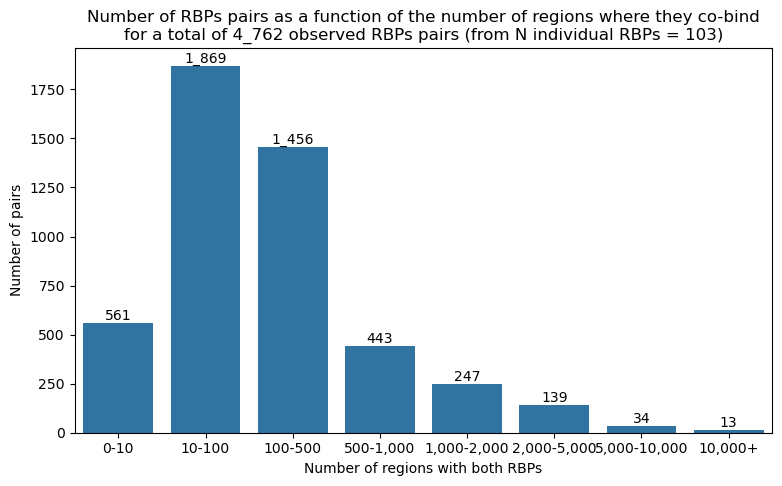

In [22]:
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111)

sns.barplot(
    data=pair_counts_df["count_bin"].value_counts().reset_index(),
    x="count_bin",
    y="count",
    order=bins_labels,
    ax=ax1,
)

# Add label on top of each bar
for p in ax1.patches:
    if isinstance(p.get_height(), Number) and p.get_height() > 0:
        _ = ax1.annotate(
            f"{int(p.get_height()):_}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

_ = ax1.set_ylabel("Number of pairs")
_ = ax1.set_xlabel("Number of regions with both RBPs")

_ = ax1.set_title(
    "Number of RBPs pairs as a function of the number of regions where they co-bind\n"
    f"for a total of {len(pair_counts_df):_} observed RBPs pairs "
    f"(from N individual RBPs = {len(set(pair_counts_df['p1'].unique()) | set(pair_counts_df['p2'].unique())):_})"
)


In [23]:
# This table shows for a given pair of RBPs the number of regions where they were identified as co-binding.
display(pair_counts_df.head(10))

,pair,count,p1,p2,count_bin
0,"(AQR_HepG2, PRPF8_HepG2)",19408,AQR_HepG2,PRPF8_HepG2,"10,000+"
1,"(PPIG_HepG2, PRPF8_HepG2)",18436,PPIG_HepG2,PRPF8_HepG2,"10,000+"
2,"(BCLAF1_HepG2, GRWD1_HepG2)",17434,BCLAF1_HepG2,GRWD1_HepG2,"10,000+"
3,"(GRWD1_HepG2, PPIG_HepG2)",17321,GRWD1_HepG2,PPIG_HepG2,"10,000+"
4,"(EFTUD2_HepG2, PRPF8_HepG2)",15330,EFTUD2_HepG2,PRPF8_HepG2,"10,000+"
5,"(CSTF2T_HepG2, FAM120A_HepG2)",15139,CSTF2T_HepG2,FAM120A_HepG2,"10,000+"
6,"(GRWD1_HepG2, PRPF8_HepG2)",13956,GRWD1_HepG2,PRPF8_HepG2,"10,000+"
7,"(CSTF2T_HepG2, PRPF4_HepG2)",12072,CSTF2T_HepG2,PRPF4_HepG2,"10,000+"
8,"(FAM120A_HepG2, PRPF4_HepG2)",11848,FAM120A_HepG2,PRPF4_HepG2,"10,000+"
9,"(BCLAF1_HepG2, PPIG_HepG2)",11250,BCLAF1_HepG2,PPIG_HepG2,"10,000+"


### Select a subset of RBPs

In [27]:
# Here: subset the pairs of RBPs to retain only the pairs that appear to co-bind often.
params_min_number_of_regions = 1000
pair_counts_df_filtered = pair_counts_df.loc[lambda df: df["count"] >= params_min_number_of_regions, :].copy()


# Remake the bins to have better granularity.
# TODO: this is manually defined, and might require adjustments based on the data.
bins = [1_000, 2_000, 3_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000, np.inf]
bins_labels = [f"{k1:,}-{k2:,}" for k1, k2 in itt.pairwise(bins[:-1])] + [f"{bins[-2]:,}+"]

pair_counts_df_filtered["count_bin"] = pd.cut(
    pair_counts_df["count"],
    bins=bins,
    labels=bins_labels,
)

# Rename the p1, p2 to remove the cell-line suffixes ("_HepG2" or "_K562").
pair_counts_df_filtered = pair_counts_df_filtered.assign(
    p1=lambda df: df["p1"].str.split("_").str[0],
    p2=lambda df: df["p2"].str.split("_").str[0],
)

# Update the pair column with the new p1, p2.
pair_counts_df_filtered["pair"] = pair_counts_df_filtered.apply(
    lambda row: tuple(sorted([row["p1"], row["p2"]])), axis=1
)

display(pair_counts_df_filtered.head(10))

,pair,count,p1,p2,count_bin
0,"(AQR, PRPF8)",19408,AQR,PRPF8,"10,000+"
1,"(PPIG, PRPF8)",18436,PPIG,PRPF8,"10,000+"
2,"(BCLAF1, GRWD1)",17434,BCLAF1,GRWD1,"10,000+"
3,"(GRWD1, PPIG)",17321,GRWD1,PPIG,"10,000+"
4,"(EFTUD2, PRPF8)",15330,EFTUD2,PRPF8,"10,000+"
5,"(CSTF2T, FAM120A)",15139,CSTF2T,FAM120A,"10,000+"
6,"(GRWD1, PRPF8)",13956,GRWD1,PRPF8,"10,000+"
7,"(CSTF2T, PRPF4)",12072,CSTF2T,PRPF4,"10,000+"
8,"(FAM120A, PRPF4)",11848,FAM120A,PRPF4,"10,000+"
9,"(BCLAF1, PPIG)",11250,BCLAF1,PPIG,"10,000+"


In [28]:
# We apply a network representation of this table so as to further select and segment the set of RBPs.
full_network = networkx.from_pandas_edgelist(
    pair_counts_df_filtered,
    source="p1",
    target="p2",
    edge_attr="count",
)

# Detect communities (disconnected sets of nodes), only retain the largest one.
communities = networkx.algorithms.community.greedy_modularity_communities(full_network)
communities = sorted(communities, key=len, reverse=True)

# Now, select only the top 3 largest communities.
N_MAX_COMMUNITIES = 3
MIN_COMMUNITY_SIZE = 3

subset_communities = [c for c in communities if len(c) >= MIN_COMMUNITY_SIZE][:N_MAX_COMMUNITIES]
subset_networks = [full_network.subgraph(subset_community).copy() for subset_community in subset_communities]

In [29]:
# We can annotate each community with the functions of the RBPs in it, to get a biological context of the community
# (i.e. why they might co-bind).

for community in subset_communities:
    print(f"Community size: {len(community):_}")
    print("RBPs in the community:")
    print(", ".join(sorted(community)))

    display(rbp_functions.loc[community, :].sum(axis=0).loc[lambda v: v > 2].sort_values(ascending=False))
    print("\n")

Community size: 26
RBPs in the community:
AGGF1, CDC40, CSTF2T, DDX3X, DGCR8, DROSHA, EFTUD2, FAM120A, FASTKD2, FKBP4, FUS, GRSF1, GTF2F1, HNRNPL, HNRNPUL1, NCBP2, NKRF, PRPF4, RBFOX2, RBM5, SFPQ, SLTM, STAU2, XPO5, XRN2, YBX3


Splicing regulation      8
microRNA processing      6
Spliceosome              5
RNA stability & decay    4
RNA export               4
RNA localization         3
dtype: int64



Community size: 25
RBPs in the community:
AQR, BCLAF1, BUD13, EIF3H, FXR2, G3BP1, GRWD1, HLTF, KHSRP, PPIG, PRPF8, RBM15, RBM22, RPS3, SDAD1, SF3A3, SF3B4, SND1, SRSF1, SUPV3L1, TRA2A, U2AF1, U2AF2, UCHL5, ZNF800


Splicing regulation       11
Spliceosome                8
RNA stability & decay      6
Translation regulation     4
RNA localization           3
RNA export                 3
dtype: int64



Community size: 16
RBPs in the community:
AKAP1, DDX55, FUBP3, IGF2BP1, IGF2BP3, LARP4, LIN28B, LSM11, PABPN1, PCBP1, PCBP2, SUB1, TIA1, TIAL1, UPF1, ZC3H11A


Translation regulation    10
RNA stability & decay      8
Splicing regulation        4
RNA localization           3
RNA export                 3
dtype: int64

### Visualize the networks

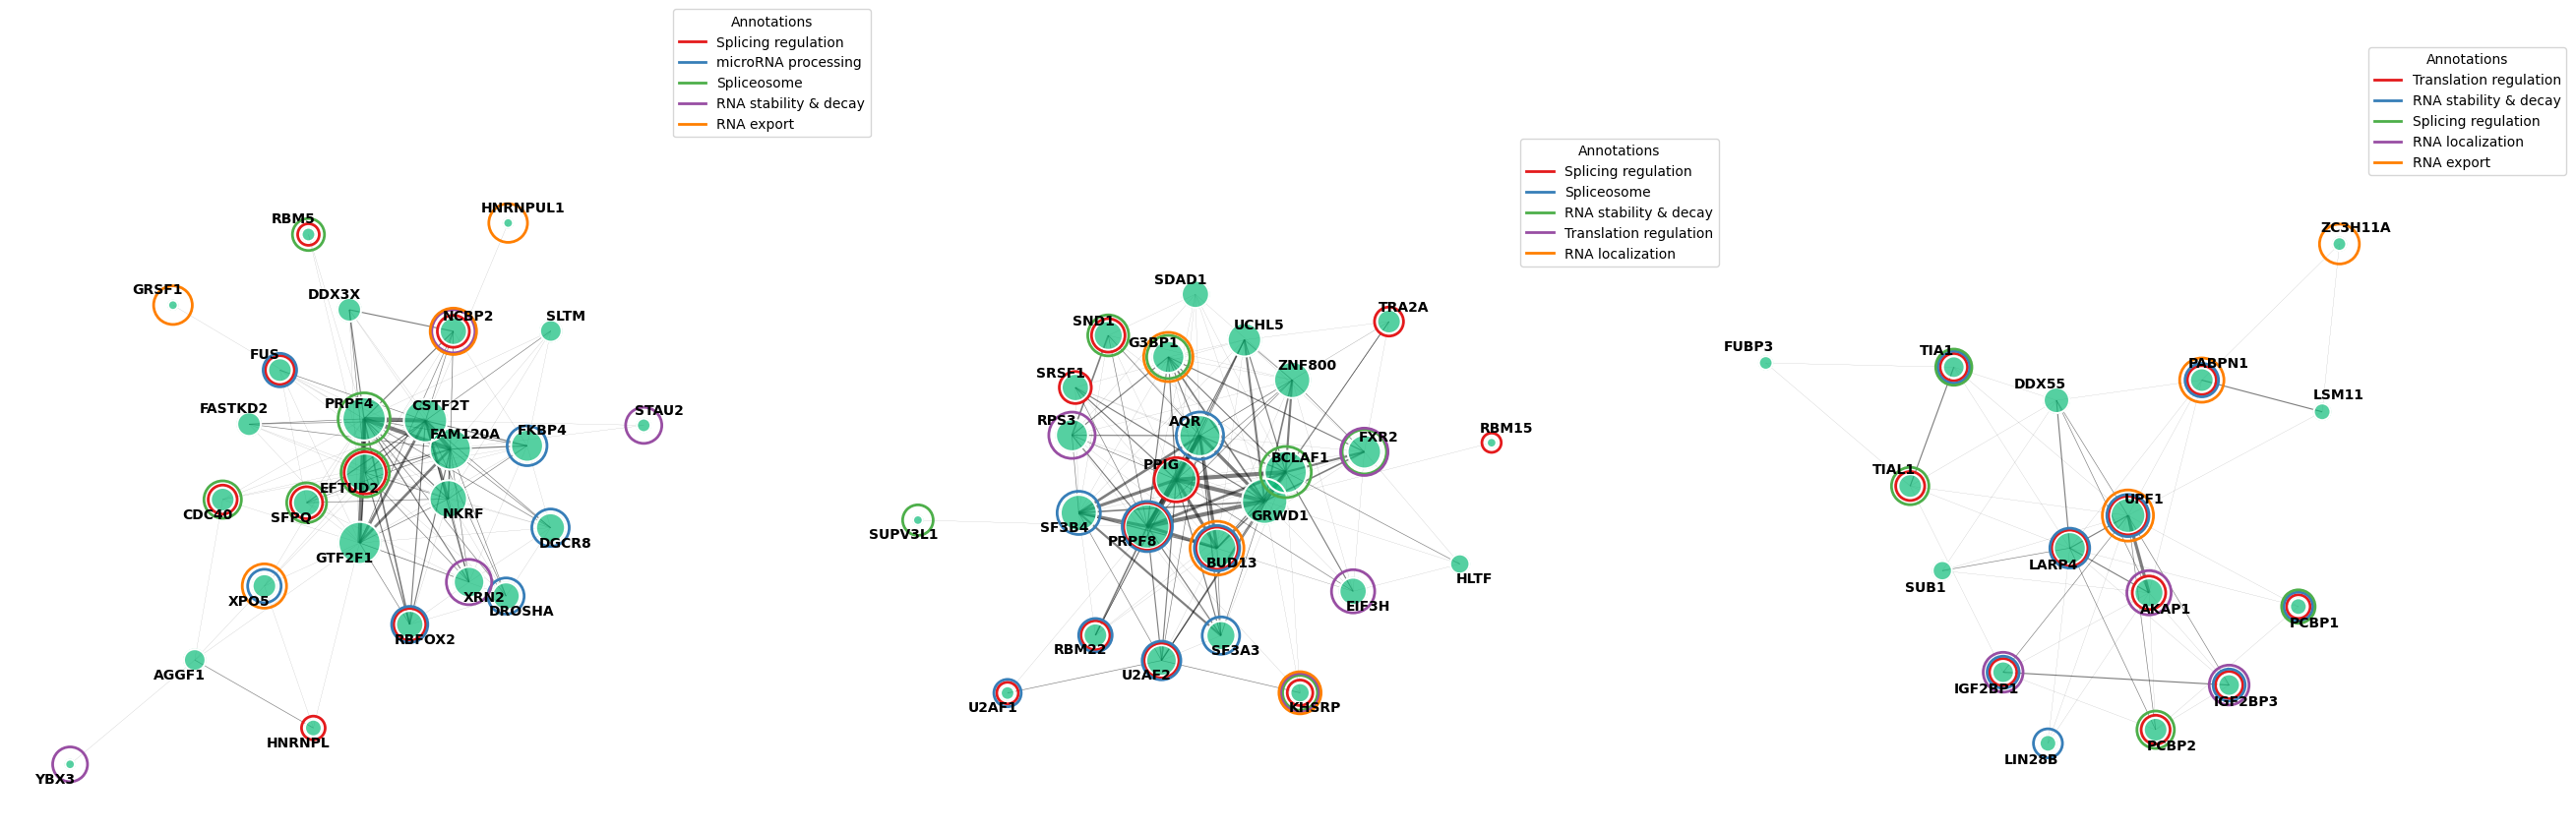

In [ ]:
# Visualize the sub-networks
# ==========================


# Visualize the edges width corresponding to their counts.
# Use the "count" bin rather than the actual count to avoid too large widths.
map_bins_to_widths = dict(zip(bins_labels, np.linspace(0.1, 3.0, len(bins_labels)).tolist()))

# We will display annotations on the nodes, from the RBP functions.
# Since one RBP can have multiple functions, we limit the number of annotations per node.
# We also focus on the set of annotations that are most frequent in the RBPs in the networks.
min_number_of_rbps_per_annotation = 2
max_number_of_annotations = 5


map_function_to_rbps_list = rbp_functions.T.apply(lambda row: row[row > 0].index.tolist(), axis=1).to_dict()


fig = plt.figure(figsize=(26, 14))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)


# NOTE: if there are less than 3 networks, this will work correctly (as zipping will stop at the shortest iterable).
for ax, network in zip([ax1, ax2, ax3], subset_networks):
    # PREPARE
    # -------

    # Increase the spread of the nodes with a different layout

    pos = networkx.shell_layout(network)
    pos = networkx.kamada_kawai_layout(network)
    # pos = networkx.spring_layout(network, seed=42)

    # DRAW NODES
    # ----------

    # Visualize the nodes with size matching their degree
    node_sizes = [50 * network.degree(n) for n in network.nodes()]
    # Make it a dict for later use (retrieving the size of a node by its name)
    node_sizes_dict = dict(zip(network.nodes(), node_sizes))

    networkx.draw_networkx_nodes(
        network,
        pos,
        node_size=node_sizes,
        node_color="#0DBC79",
        alpha=0.7,
        ax=ax,
    )

    # Repeat to add a white line around the nodes ; no face color ; alpha = 1
    networkx.draw_networkx_nodes(
        network,
        pos,
        nodelist=network.nodes(),
        node_size=node_sizes,
        node_color="none",  # no fill
        edgecolors="white",
        linewidths=1.5,
        alpha=1.0,
        ax=ax,
    )

    # ANNOTATE NODES
    # --------------

    # Get RBP function annotations to be added as visual elements on the nodes.

    # This provides a Series of annotations
    rbp_functions_subset = (
        rbp_functions.loc[list(network.nodes()), :]
        .sum(axis=0)
        .sort_values(ascending=False)
        .loc[lambda v: v > min_number_of_rbps_per_annotation]
    ).head(max_number_of_annotations)

    # Map annotations to colors
    annotations_to_colors = dict(
        zip(rbp_functions_subset.index, sns.color_palette("Set1", n_colors=len(rbp_functions_subset)))
    )

    offset = 150  # how much larger the annotation ring is

    for i, annotation in enumerate(rbp_functions_subset.index):
        nodes_with_annot = [n for n in network.nodes() if n in map_function_to_rbps_list[annotation]]
        if len(nodes_with_annot) == 0:
            continue

        sizes = [node_sizes_dict[n] + (i + 1) * offset for n in nodes_with_annot]

        networkx.draw_networkx_nodes(
            network,
            pos,
            nodelist=nodes_with_annot,
            node_size=sizes,
            node_color="none",  # no fill
            edgecolors=annotations_to_colors[annotation],
            linewidths=2,
            alpha=1.0,
            ax=ax,
        )

    # EDGES
    # -----

    # Draw the edges with the widths corresponding to the counts
    pair_set_to_count_bin = (
        pair_counts_df_filtered.loc[:, ["pair", "count_bin"]].set_index("pair")["count_bin"]
    ).to_dict()
    # Update the dict with the pairs (p2, p1)
    pair_set_to_count_bin.update({(u[1], u[0]): v for (u, v) in pair_set_to_count_bin.items()})

    edge_widths = [map_bins_to_widths[pair_set_to_count_bin[edge_pair]] for edge_pair in network.edges()]

    networkx.draw_networkx_edges(
        network,
        pos,
        width=edge_widths,
        edge_color="black",
        alpha=0.5,
        ax=ax,
    )

    # LABELS
    # ------

    # Add the labels of the nodes
    networkx.draw_networkx_labels(
        network,
        {k: (v + np.array([np.sign(v[0]), np.sign(v[1])]) * 0.05) for k, v in pos.items()},
        labels={n: n for n in network.nodes()},
        # Make font bold
        font_weight="bold",
        font_size=10,
        ax=ax,
    )

    # OTHER
    # -----

    # DEBUG : show the center of the plot so as to understand the coordinate system.
    ## Add a circle at position 0, 0
    # circle = mpl.patches.Circle((0, 0), radius=0.1, color="red", fill=False, lw=2)
    # ax.add_patch(circle)

    # Prevent distortion of the plots (aspect ratio)
    ax.set_aspect("equal")

    # Add the legend
    # Create Line2D handles for legend
    legend_elements = [
        mpl.lines.Line2D([0], [0], color=color, lw=2, label=label) for label, color in annotations_to_colors.items()
    ]

    # Add legend to plot
    ax.legend(handles=legend_elements, title="Annotations", loc="upper right", bbox_to_anchor=(1.25, 1.25))

    # Make the legend over any other elements
    ax.legend_.set_zorder(100)

    # Remove the borders of the plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # Remove background color (make it transparent)
    ax.set_facecolor("none")


plt.tight_layout()

EXPORT = False
if EXPORT:
    filepath = Path("rbp_networks.svg")
    plt.savefig(filepath, format="svg", dpi=300, bbox_inches="tight")


/home/l10n/projects/ml4rg25-parnet/parnet_demo/.pixi/envs/parnet-demo-gpu/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/l10n/projects/ml4rg25-parnet/parnet_demo/.pixi/envs/parnet-demo-gpu/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/tmp/ipykernel_509272/2850544389.py:77: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


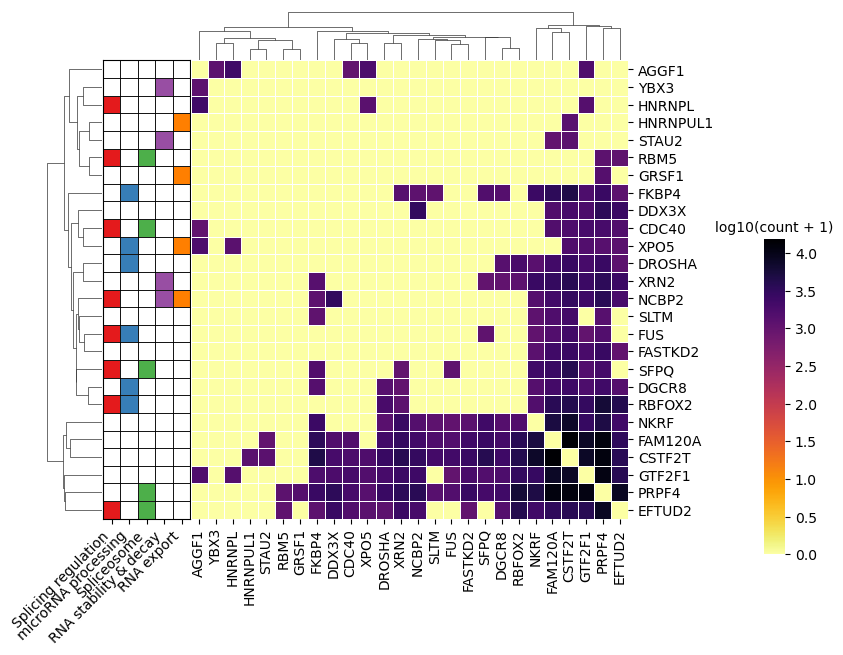

In [150]:
# NOTE : This cannot be put in a single figure, you will have to run it separately for each community.

network = subset_networks[0]
adj_mat = networkx.to_pandas_adjacency(network, weight="count").map(lambda v: np.log10(v + 1))


# This provides a Series of annotations
min_number_of_rbps_per_annotation = 2
max_number_of_annotations = 5

rbp_functions_subset = (
    rbp_functions.loc[list(network.nodes()), :]
    .sum(axis=0)
    .sort_values(ascending=False)
    .loc[lambda v: v > min_number_of_rbps_per_annotation]
).head(max_number_of_annotations)

# Map annotations to colors
annotations_to_colors = dict(
    zip(rbp_functions_subset.index, sns.color_palette("Set1", n_colors=len(rbp_functions_subset)))
)

# Prepare the annotations dataframe ; here : row index are the RBPs, and columns are the annotations.
annotations_df = rbp_functions.loc[list(network.nodes()), rbp_functions_subset.index]
# Now we fill in the values with the colors
annotations_df = annotations_df.apply(
    lambda column: [annotations_to_colors[column.name] if value == 1 else "#FFFFFF" for value in column.values]
)


g = sns.clustermap(
    adj_mat,
    dendrogram_ratio=(0.1, 0.1),
    linewidths=0.5,
    linecolor="white",
    cmap="inferno_r",
    figsize=(7, 7),
    row_colors=annotations_df,
    # Make sure all labels are visible
    xticklabels=True,
    yticklabels=True,
)

# POST PROCESS
# ============

# Row colors annotation heatmap
# -----------------------------

ax = g.ax_row_colors
for spine in ax.spines.values():
    spine.set_visible(True)

# Add grid manually
n_colors = annotations_df.shape[0] if isinstance(annotations_df, pd.DataFrame) else 1
n_rows = annotations_df.shape[1] if isinstance(annotations_df, pd.DataFrame) else len(annotations_df)

for i in range(n_rows):
    for j in range(n_colors):
        ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=False, edgecolor="black", linewidth=0.5))

# Apply rotation to the x-tick labels
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")


# Colorbar
# --------

# Adjust colorbar position
g.cax.set_position([1.05, 0.2, 0.03, 0.45])
# Add title
_ = g.cax.set_title("log10(count + 1)", fontsize=10)


plt.tight_layout()

## Intervals with peaks from selected RBPs

Here: reuse the previously identified regions with co-binding of RBPs, to :

1. filter for the regions where the selected RBPs are present;
2. extract fixed-length intervals from these regions
3. verify the presence of peaks from the selected RBPs in these intervals.

In the `## Postprocess` section, we will demonstrate how to annotate positions within an interval with peaks and other annotations,
so as to check the predictions of the PARNET model at these positions.

In [ ]:
def retrieve_set_of_regions_with_rbps_from_community(
    closeby_peaks_df: pd.DataFrame,
    community: set[str],
) -> pd.DataFrame:
    print(list(sorted(community)))

    # First: get the set of regions with actual close-by peaks from more than one RBP.
    tmp = closeby_peaks_df.loc[lambda df: df["num"] > 1, :].copy()

    # Convert the comma-separated list of RBPs into sets.
    tmp["list"] = tmp["list"].apply(lambda v: set(v.replace("_HepG2", "").split(",")))

    # Now use the sets to get the subset of regions that have their RBPs belonging to the RBP-community of interest.
    tmp = tmp.loc[lambda df: df["list"].map(lambda v: len(v & community)) > 1, :]

    # Convert back to string.
    tmp["list"] = tmp["list"].apply(lambda v: ",".join(sorted(v)))

    # Now make intervals of length 201, centered on the current intervals
    tmp = tmp.assign(start=lambda df: df["start"] + (df["end"] - df["start"]) // 2).assign(
        end=lambda df: df["start"] + 1
    )
    tmp = pbt.BedTool.from_dataframe(tmp).slop(b=100, s=True, g=genome_filepath).to_dataframe()
    return tmp

In [284]:
regions_communities = []

for community in communities[:3]:
    print(f"Processing community with {len(community):_} RBPs")
    tmp = retrieve_set_of_regions_with_rbps_from_community(closeby_peaks_df, community)
    print(tmp.shape)
    regions_communities.append(tmp)
    print("\n")

# Subsample for the sake of computation time.

NMAX_REGIONS = 10_000
regions_communities = [
    tmp.sample(n=NMAX_REGIONS, random_state=42, replace=False).sort_values(by=["chrom", "start"]).reset_index(drop=True)
    for tmp in regions_communities
]

for regions_community in regions_communities:
    print(f"Number of regions in the community: {regions_community.shape[0]:_}")

Processing community with 26 RBPs
['AGGF1', 'CDC40', 'CSTF2T', 'DDX3X', 'DGCR8', 'DROSHA', 'EFTUD2', 'FAM120A', 'FASTKD2', 'FKBP4', 'FUS', 'GRSF1', 'GTF2F1', 'HNRNPL', 'HNRNPUL1', 'NCBP2', 'NKRF', 'PRPF4', 'RBFOX2', 'RBM5', 'SFPQ', 'SLTM', 'STAU2', 'XPO5', 'XRN2', 'YBX3']
(59749, 6)


Processing community with 25 RBPs
['AQR', 'BCLAF1', 'BUD13', 'EIF3H', 'FXR2', 'G3BP1', 'GRWD1', 'HLTF', 'KHSRP', 'PPIG', 'PRPF8', 'RBM15', 'RBM22', 'RPS3', 'SDAD1', 'SF3A3', 'SF3B4', 'SND1', 'SRSF1', 'SUPV3L1', 'TRA2A', 'U2AF1', 'U2AF2', 'UCHL5', 'ZNF800']
(123491, 6)


Processing community with 16 RBPs
['AKAP1', 'DDX55', 'FUBP3', 'IGF2BP1', 'IGF2BP3', 'LARP4', 'LIN28B', 'LSM11', 'PABPN1', 'PCBP1', 'PCBP2', 'SUB1', 'TIA1', 'TIAL1', 'UPF1', 'ZC3H11A']
(32947, 6)


Number of regions in the community: 10_000
Number of regions in the community: 10_000
Number of regions in the community: 10_000


In [285]:
# Here: we will group the intervals on the list of RBPs expected to co-bind together in the region.
# Then for each group we can verify this co-binding in the fixed-length interval by intersecting the peaks,
# and verifying their presence.

results = []

for processed_intervals_community in regions_communities:
    processed_intervals_community_grouped = processed_intervals_community.groupby("name")

    per_community_intersect_processed_intervals = {}

    for i, (name, group) in enumerate(processed_intervals_community_grouped):
        if i % 100 == 0 or i < 10:
            print(
                f"{datetime.datetime.now()} - ({i + 1:_} / {len(processed_intervals_community_grouped):_}) - Processing group: {name}"
            )

        rbps_set = name.split(",")

        rbps_set_peaks_bt = [
            bt for rbp_ct, bt in zip(peaks_rbp_ct_list, peaks_rbp_ct_bt) if rbp_ct.split("_")[0] in rbps_set
        ]

        rbps_set_peaks_bt_fn = [bt.fn for bt in rbps_set_peaks_bt]
        rbps_set_names = [rbp_ct for rbp_ct in peaks_rbp_ct_list if rbp_ct.split("_")[0] in rbps_set]

        # Here: we use the index to name the regions.
        bt_group = pbt.BedTool.from_dataframe(
            group.reset_index(drop=True).reset_index().loc[:, ["chrom", "start", "end", "index", "score", "strand"]]
        )

        # Here we do not use the `multiinter` method, but rather the `intersect` method
        # which will preserve the "source" intervals while it can intersect with a list of bedtools objects.
        # The resulting df will repeat the source interval(s) for each intersection with the peaks.

        intersect = bt_group.intersect(
            rbps_set_peaks_bt[:3],
            wao=True,
            s=True,
            F=0.5,
        ).to_dataframe(names=[])

        # The resulting dataframe is a bit malformed, here we retrieve the bed6 columns
        # from source region and peak region + overlap length, and rename accordingly.
        intersect = intersect.reset_index().iloc[:, list(range(2 * 6)) + [-1]]

        intersect.columns = ["a." + c for c in bed6_cols] + ["b." + c for c in bed6_cols] + ["ol"]

        # Drop regions that have only one peak intersected. This can be identified by keeping only the rows where 'a.name'
        # has a count higher than 1 when grouping on 'a.name'
        intersect_sub = intersect.loc[
            lambda df: df["a.name"].isin(intersect.groupby("a.name").size().loc[lambda v: v > 1].index), :
        ]

        per_community_intersect_processed_intervals[name] = intersect_sub.copy()

    # No need to maintain the dict structure, as the name is already present in the `a.name` column.
    results.append(
        pd.concat(per_community_intersect_processed_intervals.values(), axis=0)
        .sort_values(by=["a.chrom", "a.start"])
        .reset_index(drop=True)
    )

2025-07-16 12:23:49.378800 - (1 / 6_670) - Processing group: AGGF1,AKAP1,AQR,CDC40,CSTF2,DDX6,DROSHA,FTO,GTF2F1,HNRNPL,LARP4,NCBP2,STAU2,XPO5,YBX3
2025-07-16 12:23:49.527309 - (2 / 6_670) - Processing group: AGGF1,AKAP1,BCLAF1,DDX3X,DDX55,LARP4,RBM15,RPS3,TROVE2,ZC3H11A
2025-07-16 12:23:49.750066 - (3 / 6_670) - Processing group: AGGF1,AKAP1,CDC40,CSTF2,DDX52,EFTUD2,EIF3D,GTF2F1,HNRNPK,HNRNPL,LARP4,SUB1,SUPV3L1,XPO5,YBX3,ZC3H11A,ZNF800
2025-07-16 12:23:49.814694 - (4 / 6_670) - Processing group: AGGF1,AKAP1,CDC40,CSTF2,DDX52,EFTUD2,EIF3D,GTF2F1,HNRNPL,LARP4,SUB1,SUPV3L1,XPO5,YBX3,ZC3H11A,ZNF800
2025-07-16 12:23:49.878661 - (5 / 6_670) - Processing group: AGGF1,AKAP1,CDC40,CSTF2,DDX52,EIF3D,GTF2F1,HNRNPL,LARP4,SUB1,SUPV3L1,XPO5,YBX3,ZC3H11A,ZNF800
2025-07-16 12:23:49.943610 - (6 / 6_670) - Processing group: AGGF1,AKAP1,CDC40,CSTF2,DDX52,GTF2F1,HNRNPL,LARP4,SUB1,SUPV3L1,XPO5,YBX3,ZC3H11A,ZNF800
2025-07-16 12:23:50.006201 - (7 / 6_670) - Processing group: AGGF1,AKAP1,CDC40,CSTF2,EIF3D,GTF

In [291]:
display(results[0].head(20))


,a.chrom,a.start,a.end,a.name,a.score,a.strand,b.chrom,b.start,b.end,b.name,b.score,b.strand,ol
0,chr1,960561,960762,0,3,+,chr1,960637,960701,CSTF2T_HepG2_0,1000,+,64
1,chr1,960561,960762,0,3,+,chr1,960638,960734,NCBP2_HepG2_1,1000,+,96
2,chr1,960641,960842,0,5,+,chr1,960637,960701,CSTF2T_HepG2_0,1000,+,60
3,chr1,960641,960842,0,5,+,chr1,960809,960866,CSTF2T_HepG2_1,1000,+,33
4,chr1,960641,960842,0,5,+,chr1,960638,960734,NCBP2_HepG2_1,1000,+,93
5,chr1,999877,1000078,0,4,-,chr1,999983,1000068,DDX3X_HepG2_0,1000,-,85
6,chr1,999877,1000078,0,4,-,chr1,999967,1000098,NCBP2_HepG2_2,1000,-,111
7,chr1,999900,1000101,0,3,-,chr1,999983,1000068,DDX3X_HepG2_0,1000,-,85
8,chr1,999900,1000101,0,3,-,chr1,999967,1000098,NCBP2_HepG2_2,1000,-,131
9,chr1,1036345,1036546,0,5,+,chr1,1036366,1036451,CSTF2T_HepG2_52,1000,+,85


## Export

In [294]:
results[0].to_csv("segments_with_peaks.community_0.tsv", sep="\t", index=False, header=True)
results[1].to_csv("segments_with_peaks.community_1.tsv", sep="\t", index=False, header=True)
results[2].to_csv("segments_with_peaks.community_2.tsv", sep="\t", index=False, header=True)


In [ ]:
pair_counts_df_filtered.to_csv("rbp_pairs_counts_filtered.tsv", sep="\t", index=False, header=True)

In [298]:
for i, network in enumerate(subset_networks):
    adj_mat = networkx.to_pandas_adjacency(network, weight="count")
    adj_mat.to_csv(f"adjacency_matrix.community_{i}.tsv", sep="\t", index=True, header=True)

## Postprocess

### Annotate a given region with peaks and genomic annotations

Given a segment with multiple RBPs intersecting:

- Reposition segment:
  - Recenter the segment basing on the coordinates from the most upstream and downstream peak within.
  - Define different extension lengths from the newly defined center.

- Annotate each position of the segment with the RBP binding information:
  - For each position, keep the list of RBPs that bind at this position.

- Annotate segments with genomic annotations:
  - Maintain per position annotations.
  - Application: from a given centered region, can we evaluate whether extending the region into 
    a different (set of) biotype(s) changes the representations in the window.
  - e.g. : peaks in intronic regions : if the region gets extended into exon, are the representation of the peaks affected?

### Annotate a given region with motifs hits

In [292]:
# /home/l10n/research/projects/hzm/ntras_lncrna/data_preprocessing/oRNAment/raw/general/PWMs/
# NOTE: can use the content of conv.sh to convert back the IDs to names.
# NOTE: the students are working with catRAPID motifs; for the sake of time they will continue with these.